In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from numpy import random
from sklearn.model_selection import train_test_split
import os
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
from random import seed
from random import randrange
import timeit
import tensorflow as tf
%load_ext autoreload
%autoreload
%reload_ext autoreload
from Scripts import plot
from Scripts import ECG_processing
from Scripts import metrics
from scipy import optimize

In [2]:
def thr_acc_metrics(thr, label, output_prob):
    return -metrics.compute_accuracy(label, np.array(output_prob>thr))

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')


In [4]:
train_data = pd.read_csv('./Data/train_data_ptb.csv')

In [5]:
test_data = pd.read_csv('./Data/test_data_ptb.csv')

In [6]:
train_data

,Unnamed: 0,gender,age,R HR STD,R HR median,R HR min,R HR max,R HR mean,RMSSD,R amp II std,...,t_offset_median,t_offset_min,t_offset_max,mean_t_offset,t_onsets_std,t_onsets_median,t_onsets_min,t_onsets_max,mean_t_onsets,Labels
0,0,2.0,-1.0,35.022173,64.242480,62.240664,178.571429,78.968869,7462.634770,0.098937,...,65.865579,61.855670,288.461538,89.609104,61.288462,65.077147,60.483871,270.270270,87.847241,['NORM']
1,1,2.0,-1.0,23.360239,50.726668,43.795620,116.731518,60.291780,4180.799504,0.522686,...,50.251256,43.352601,97.719870,60.381687,21.792238,48.701299,41.551247,97.719870,60.685624,['NORM']
2,2,2.0,-1.0,27.444595,64.308756,61.475410,138.888889,77.215155,6715.386001,0.260972,...,66.080578,51.993068,180.722892,79.872997,48.470414,65.011598,53.475936,223.880597,82.741229,['NORM']
3,3,2.0,-1.0,3.937792,76.142622,68.649886,83.102493,75.315293,5687.899616,0.411491,...,74.074074,69.124424,82.417582,74.724755,3.361471,74.165750,68.181818,78.947368,74.100926,['NORM']
4,4,2.0,-1.0,3.568312,66.519174,60.975610,72.289157,66.474286,4431.563492,0.127395,...,65.288434,60.483871,73.170732,66.478167,3.622490,65.502183,62.761506,73.891626,66.544697,['NORM']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19603,19603,2.0,-1.0,10.235809,107.720275,85.714286,142.180095,108.752499,11931.877900,0.407431,...,106.382979,65.359477,135.135135,103.745420,16.437627,107.913669,67.264574,137.614679,104.168044,['NORM']
19604,19604,2.0,-1.0,4.089769,67.267618,65.789474,80.428954,68.441891,4701.018623,0.090460,...,67.114094,64.516129,68.807339,67.256308,2.235809,66.964286,62.761506,70.588235,66.989704,['CD']
19605,19605,2.0,-1.0,38.461356,81.146063,55.045872,171.428571,92.664642,10066.011663,0.308788,...,72.639225,54.644809,263.157895,102.831542,53.624632,75.566751,54.249548,196.078431,99.489230,['CD']
19606,19606,2.0,-1.0,10.795504,69.204981,58.027079,101.694915,71.262827,5194.933469,0.028010,...,68.181818,56.603774,105.263158,71.615786,11.696963,68.649886,58.708415,102.739726,71.375763,"['CD', 'STTC', 'MI']"


In [7]:
# Preprocessing
print(np.where(test_data.iloc[:,:-1].isna()))
print(test_data.index[np.isinf(test_data.iloc[:,:-1]).any(1)])
#print(test_data.columns.to_series()[np.isinf(test_data.iloc[:,:-1]).any()])

count = 0
while len(np.where(test_data.iloc[:,:-1].isna())[1]) != 0:
    try:
        for i,j in enumerate(np.where(test_data.iloc[:,:-1].isna())[0]):
            print("-------")
            print(i)
            print(j)
            print(np.where(test_data.iloc[:,:-1].isna())[1][i])
            print(test_data.iloc[j,np.where(test_data.iloc[:,:-1].isna())[1][i]])
            test_data.iloc[j,np.where(test_data.iloc[:,:-1].isna())[1][i]] = test_data.iloc[:,np.where(test_data.iloc[:,:-1].isna())[1][i]].mean()
            count = count + 1
            print(count)
    except:
        continue
        
print(np.where(train_data.iloc[:,:-1].isna()))
print(train_data.index[np.isinf(train_data.iloc[:,:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,:-1]).any()])

train_data = train_data.dropna()

print(np.where(train_data.iloc[:,1:-1].isna()))
print(train_data.index[np.isinf(train_data.iloc[:,1:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,1:-1]).any()])

print(train_data.shape)

(array([1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021,
       1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1597,
       1597, 1597, 1597, 1597, 1597, 1597, 1597, 1597, 2030, 2030, 2030,
       2030, 2030, 2030, 2030, 2030, 2030], dtype=int64), array([ 86,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 107, 108, 109, 112,  86,  87,  90, 103, 104,
       107, 108, 109, 112,  86,  87,  90, 103, 104, 107, 108, 109, 112],
      dtype=int64))
Int64Index([], dtype='int64')
-------
0
1021
86
nan
1
-------
1
1021
90
nan
2
-------
2
1021
92
nan
3
-------
3
1021
94
nan
4
-------
4
1021
96
nan
5
-------
5
1021
98
nan
6
-------
6
1021
100
nan
7
-------
7
1021
102
nan
8
-------
8
1021
104
nan
9
-------
9
1021
108
nan
10
-------
10
1021
112
nan
11
-------
11
1021
87
nan
12
-------
12
1021
103
nan
13
-------
13
1021
107
nan
14
-------
14
1021
109
nan
15
-------
15
1021
86
14.939227040749353
16
-------
16
1021
87
75.0174771053058

(array([], dtype=int64), array([], dtype=int64))
Int64Index([], dtype='int64')
(19564, 114)


In [8]:
y_train = train_data['Labels'].str.lstrip("'[").str.rstrip("]'").str.replace("'", "").str.replace(" ", "")

In [9]:
y_test = test_data['Labels'].str.lstrip("'[").str.rstrip("]'").str.replace("'", "").str.replace(" ", "")

In [10]:
X_train = train_data.iloc[:,1:-1]

In [11]:
X_test = test_data.iloc[:,1:-1]

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
y_train_ohe=one_hot.fit_transform(y_train.str.split(','))
print(one_hot.classes_)
print("classes: {}".format(y_train_ohe.shape[1]))

['' 'CD' 'HYP' 'MI' 'NORM' 'STTC']
classes: 6


In [13]:
y_test_ohe = one_hot.transform(y_test.str.split(','))
print("classes: {}".format(y_test_ohe.shape[1]))

classes: 6


In [14]:
y_test_ohe = np.delete(y_test_ohe, 0, axis=1)

In [15]:
y_train_ohe = np.delete(y_train_ohe, 0, axis=1)

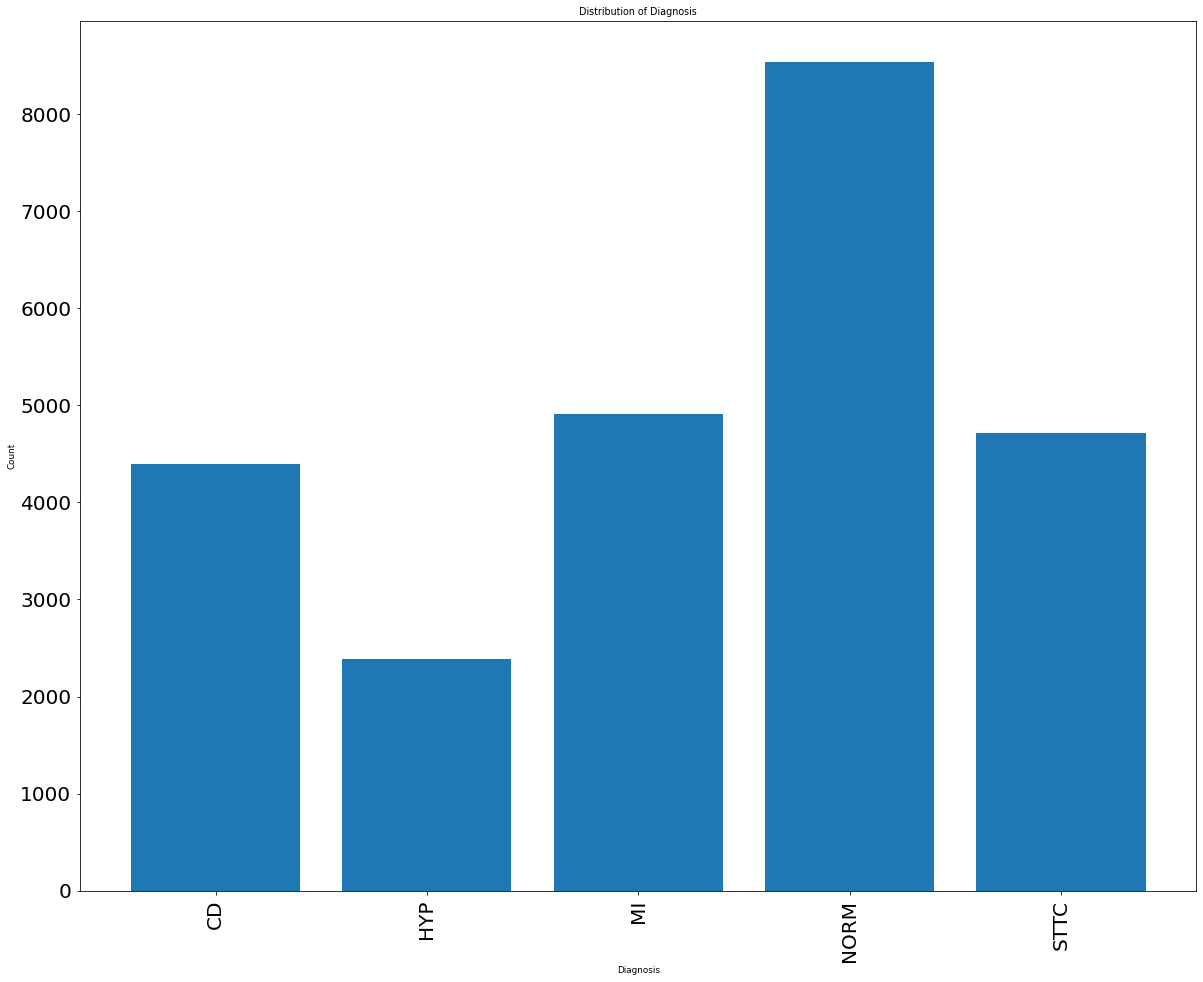

In [19]:
plot.plot_classes(one_hot.classes_[1:],y_train_ohe, plot_name = "./Results/ECG_results/distribution_training")

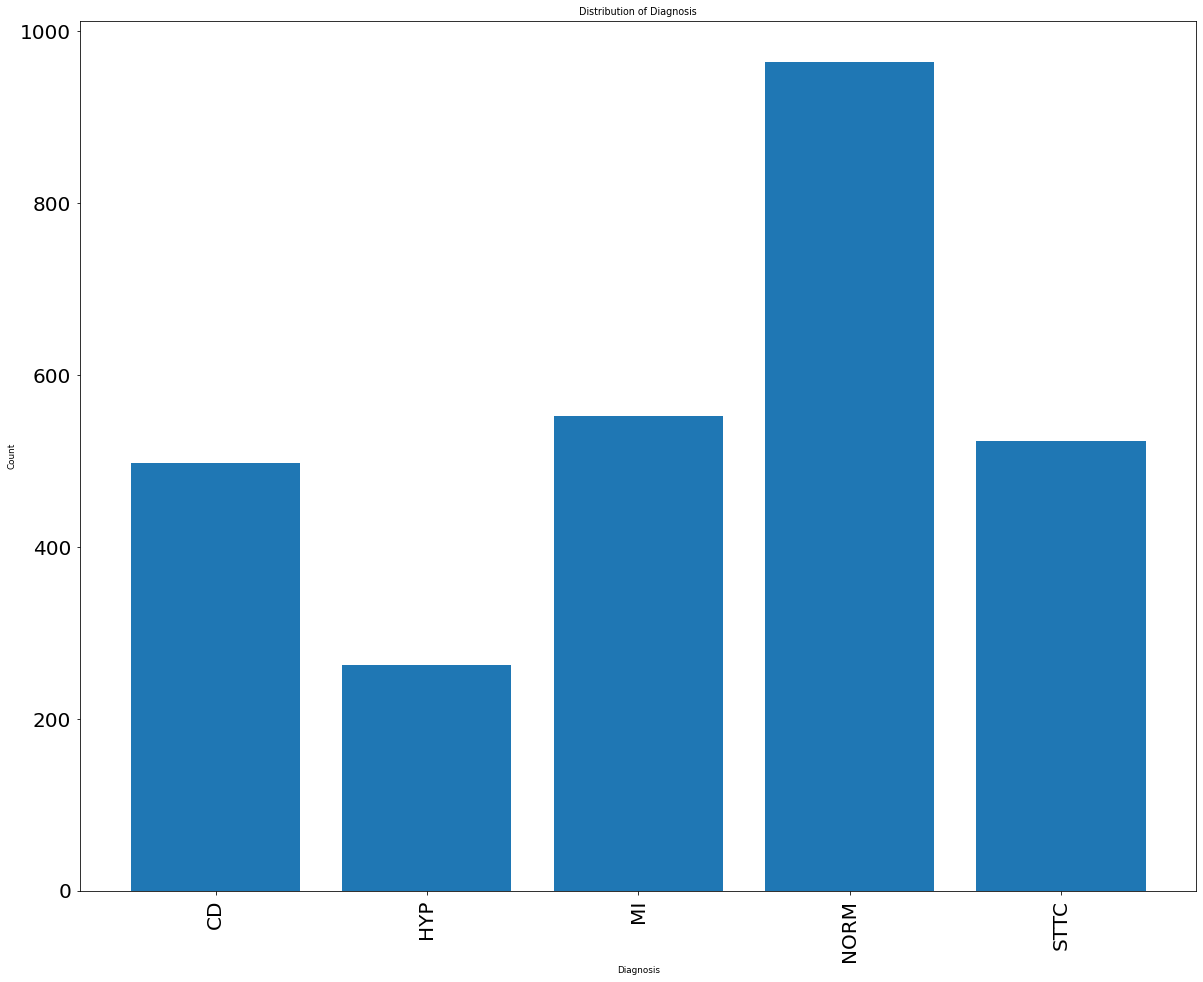

In [20]:
plot.plot_classes(one_hot.classes_[1:],y_test_ohe,plot_name = "./Results/ECG_results/distribution_test")

In [21]:
y_train_ = ECG_processing.get_new_labels(y_train_ohe)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_train_))))

Total number of unique combinations of diagnosis: 22


In [22]:
y_test_ = ECG_processing.get_new_labels(y_test_ohe)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_test_))))

Total number of unique combinations of diagnosis: 20


In [23]:
from sklearn.model_selection import StratifiedKFold
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(y_train_ohe,y_train_))
print("Training split: {}".format(len(folds[0][0])))
print("Validation split: {}".format(len(folds[0][1])))

Training split: 17607
Validation split: 1957


In [24]:
def mlp_clf(input_dim, output_dim, lr = 0.01, hidden_units = 100, n_hidden_l = 1 ,activation_hidden="relu", bias_init="zeros", weigth_init="RandomNormal"):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hidden_units, input_dim=input_dim, activation=activation_hidden, use_bias=True,bias_initializer=bias_init, kernel_initializer= weigth_init))
    for i in range(n_hidden_l):
        model.add(tf.keras.layers.Dense(hidden_units, activation=activation_hidden))
    model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid'))
    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate = lr), metrics=["accuracy","AUC"])
    return model

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
model = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(200,200,200,200,200), verbose=1, max_iter=10, batch_size=100, learning_rate='adaptive', activation='relu',learning_rate_init=0.0001)

In [26]:
import kerastuner
from kerastuner import HyperModel
import tensorflow as tf
from tensorflow.keras import regularizers


class HyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units=hp.Int('unit_0', 50, 500, step=50, default=100), input_dim=112,activation=hp.Choice('act_0', values=['relu', 'elu', 'selu'], default='relu')))
        for i in range(hp.Int('number_of_layers',1,10,step=1, default=5)):
            model.add(tf.keras.layers.Dense(units=hp.Int('unit_{}'.format(i+1), 50, 500, step=50, default=100), activation=hp.Choice('act_{}'.format(i+1), values=['relu', 'elu', 'selu'], default='relu')))

        model.add(tf.keras.layers.Dense(5, activation='sigmoid'))
        model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(learning_rate = hp.Choice('learning_rate', values=[0.00001, 0.0001, 0.001, 0.01, 0.1], default=0.001)), metrics=["accuracy","AUC"])
        return model

In [27]:
class MyTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 10, 100, step=10)
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 100, step=10)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [33]:
# This was done on Google Colab
from kerastuner.tuners import BayesianOptimization

NUM_CLASSES = one_hot.classes_[1:]
INPUT_SHAPE = 112  
SEED = 42
MAX_TRIALS = 50
EXECUTION_PER_TRIAL = 3

hypermodel = HyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

tuner = MyTuner(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='drive/My Drive/logs/fysstk_oblig',
    project_name='ECGopt11',
)

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [35]:
tuner.search(X_train_scaled[folds[0][1]],y_train_ohe[folds[0][1]], validation_split=0.2, verbose=1,)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.2000 - auc: 0.44 - ETA: 0s - loss: 0.7228 - accuracy: 0.1400 - auc: 0.44 - ETA: 0s - loss: 0.7177 - accuracy: 0.1391 - auc: 0.47 - ETA: 0s - loss: 0.7180 - accuracy: 0.1484 - auc: 0.47 - ETA: 0s - loss: 0.7178 - accuracy: 0.1523 - auc: 0.48 - ETA: 0s - loss: 0.7157 - accuracy: 0.1519 - 

NotFoundError: Failed to create a NewWriteableFile: ./hyperparameter/ECGopt\trial_ede9e8b815ac8ea06e3f71efbbc4873e\checkpoints\epoch_0\checkpoint_temp_912b6b2436aa433cacfe0f0859f9f746/part-00000-of-00001.data-00000-of-00001.tempstate6919825142764242351 : Systemet finner ikke angitt bane.
; No such process [Op:SaveV2]

In [ ]:
   # Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#results = best_model.evaluate(X_combined_test_gridsearch, y_test_gridsearch)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                5650      
_________________________________________________________________
dense_1 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
Total params: 33,655
Trainable params: 33,655
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
best_model.fit()

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>

In [60]:
#rom sklearn.metrics import fbeta_score
#from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


test_res = np.zeros(shape=(10,5))
training_res = np.zeros(shape=(10,5))


for train_index, val_index in folds:
    y_cv_train = y_train_ohe[train_index]
    X_cv_train = X_train.iloc[train_index]
    y_cv_val = y_train_ohe[val_index]
    X_cv_val = X_train.iloc[val_index]

    scaler = StandardScaler()
    scaler.fit(X_cv_train)
    X_cv_train = scaler.transform(X_cv_train)
    X_cv_val = scaler.transform(X_cv_val)
    #best_model = tuner.get_best_models(num_models=1)[0]
    #best_model.fit(X_cv_train,y_cv_train,epochs=100, batch_size=100, validation_data=(X_cv_val,y_cv_val))
    model = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(100,100,100,100), verbose=1, max_iter=10, batch_size=100, learning_rate='adaptive', activation='relu',learning_rate_init=0.0001)
    model.fit(X_cv_train,y_cv_train)
    Train_pred = model.predict(X_cv_train)

    highscore = 0
    best_thr = 0
    score_temp = 0
    for i in range(100):
        k= i*0.01*np.ones(5)
        score_temp = metrics.compute_accuracy(y_cv_train, Train_pred>k)
        if score_temp > highscore:
            highscore = score_temp
            best_thr = k
    print("best threshold:", best_thr)
    best_thr = optimize.fmin(thr_acc_metrics, args=(y_cv_train,Train_pred), x0=best_thr)
    print("best threshold:", best_thr)

    Val_pred = model.predict(X_cv_val)
    Val_pred = (Val_pred > best_thr) * 1
    print("Accuracy validation data:",metrics.compute_accuracy(y_cv_val, Val_pred))
    X_test_scaled = scaler.transform(X_test)
    Test_pred = model.predict(X_test_scaled)
    Test_pred = (Test_pred > best_thr) * 1
    print("Accuracy test data:",metrics.compute_accuracy(y_test_ohe, Test_pred))



Iteration 1, loss = 2.94802144
Iteration 2, loss = 2.75704406
Iteration 3, loss = 2.73531889
Iteration 4, loss = 2.72236389
Iteration 5, loss = 2.71254358
Iteration 6, loss = 2.70466316
Iteration 7, loss = 2.69819206
Iteration 8, loss = 2.69218956
Iteration 9, loss = 2.68747192
Iteration 10, loss = 2.68351468
best threshold: [0. 0. 0. 0. 0.]
Optimization terminated successfully.
         Current function value: -0.109275
         Iterations: 10
         Function evaluations: 33
best threshold: [ 0.0001   0.0001   0.0001   0.0001  -0.00025]
Accuracy validation data: 0.10884006131834441
Accuracy test data: 0.11030413073082161
Iteration 1, loss = 3.06385972
Iteration 2, loss = 2.76688579
Iteration 3, loss = 2.73937256
Iteration 4, loss = 2.72597003
Iteration 5, loss = 2.71661398
Iteration 6, loss = 2.70977834
Iteration 7, loss = 2.70294398
Iteration 8, loss = 2.69789801
Iteration 9, loss = 2.69354808
Iteration 10, loss = 2.68884425


KeyboardInterrupt: 

In [ ]:
model = mlp_clf(112,5)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
#model = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(100,100,100,100), verbose=1, max_iter=10, batch_size=30, learning_rate='adaptive', activation='relu',learning_rate_init=0.0001)
#model.fit(X_train_scaled,y_train_ohe)
model.fit(X_train_scaled,y_train_ohe,epochs=36, batch_size=30, validation_data=(X_test_scaled,y_test_ohe))

Epoch 1/36
653/653 [==============================] - 2s 2ms/step - loss: 0.5770 - accuracy: 0.3988 - auc: 0.5928 - val_loss: 0.5497 - val_accuracy: 0.4163 - val_auc: 0.6340
Epoch 2/36
653/653 [==============================] - 1s 2ms/step - loss: 0.5477 - accuracy: 0.4173 - auc: 0.6323 - val_loss: 0.5423 - val_accuracy: 0.4163 - val_auc: 0.6535
Epoch 3/36
653/653 [==============================] - 1s 2ms/step - loss: 0.5453 - accuracy: 0.4173 - auc: 0.6349 - val_loss: 0.5392 - val_accuracy: 0.4163 - val_auc: 0.6598
Epoch 4/36
653/653 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.4173 - auc: 0.6365 - val_loss: 0.5373 - val_accuracy: 0.4163 - val_auc: 0.6678
Epoch 5/36
653/653 [==============================] - 1s 2ms/step - loss: 0.5431 - accuracy: 0.4172 - auc: 0.6383 - val_loss: 0.5358 - val_accuracy: 0.4163 - val_auc: 0.6723
Epoch 6/36
653/653 [==============================] - 1s 2ms/step - loss: 0.5424 - accuracy: 0.4171 - auc: 0.6394 - val_loss: 0.53

In [ ]:
y_train_pred = model.predict(X_train_scaled)
highscore = 0
best_thr = 0
score_temp = 0
k=0
for i in range(100):
  k= i*0.01*np.ones(5)
  score_temp = compute_accuracy(y_train_ohe, y_train_pred>k)
  if score_temp > highscore:
    highscore = score_temp
    best_thr = k
print("best threshold:", best_thr)
new_best_thr = optimize.fmin(thr_acc_metrics, args=(y_train_ohe,y_train_pred), x0=best_thr)
print("best threshold:", new_best_thr)

best threshold: [0.33 0.33 0.33 0.33 0.33]
Optimization terminated successfully.
         Current function value: -0.416173
         Iterations: 32
         Function evaluations: 99
best threshold: [0.36294259 0.32424667 0.389395   0.22155697 0.37779083]


In [ ]:
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred>best_thr)*1

In [ ]:
compute_accuracy(y_test_ohe,y_pred)

0.4148887880163413

In [ ]:
def compute_modified_confusion_matrix_nonorm(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        #####normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0#/normalization

    return A

In [ ]:
conf_matrix = compute_modified_confusion_matrix_nonorm(y_test_ohe,y_pred)

In [ ]:
conf_matrix_df = pd.DataFrame(conf_matrix)

In [ ]:
conf_matrix_df.index = one_hot.classes_[1:]
conf_matrix_df.columns = one_hot.classes_[1:]

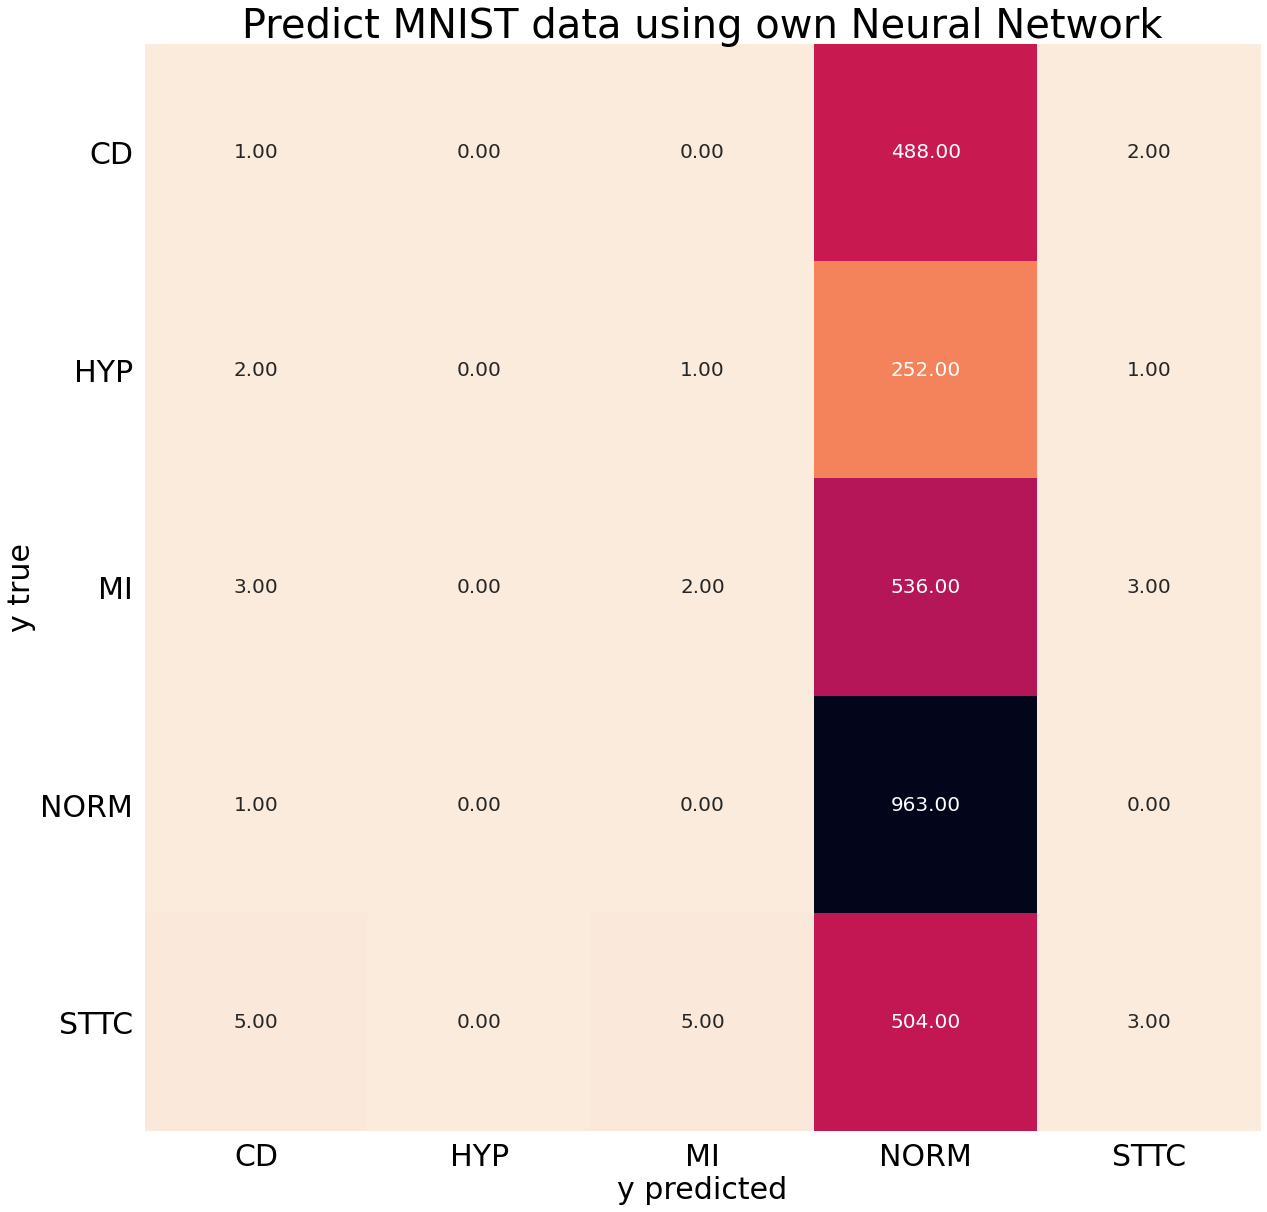

In [ ]:
import seaborn as sns
plt.figure(figsize = (20,20))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matrix_df, cmap="rocket_r", annot=True,annot_kws={"size": 20}, fmt=".2f", cbar=False)
plt.title("Predict MNIST data using own Neural Network", fontsize = 40, color= "black")
plt.xlabel("y predicted",fontsize=30, color= "black")
plt.ylabel("y true",fontsize = 30, color= "black")
plt.yticks(fontsize=30, rotation=0, color= "black")
plt.xticks(fontsize=30, rotation=0, color= "black")
#plt.savefig("Results/MNIST_confMatrix_ownNN.png",dpi=100)
plt.show()